# **1. Perkenalan Dataset**


Tahap pertama, Anda harus mencari dan menggunakan dataset **tanpa label** dengan ketentuan sebagai berikut:

1. **Sumber Dataset**:  
   Dataset dapat diperoleh dari berbagai sumber, seperti public repositories (*Kaggle*, *UCI ML Repository*, *Open Data*) atau data primer yang Anda kumpulkan sendiri.
   
2. **Ketentuan Dataset**:
   - **Tanpa label**: Dataset tidak boleh memiliki label atau kelas.
   - **Jumlah Baris**: Minimal 1000 baris untuk memastikan dataset cukup besar untuk analisis yang bermakna.
   - **Tipe Data**: Harus mengandung data **kategorikal** dan **numerikal**.
     - *Kategorikal*: Misalnya jenis kelamin, kategori produk.
     - *Numerikal*: Misalnya usia, pendapatan, harga.

3. **Pembatasan**:  
   Dataset yang sudah digunakan dalam latihan clustering (seperti customer segmentation) tidak boleh digunakan.

# **2. Import Library**

Pada tahap ini, Anda perlu mengimpor beberapa pustaka (library) Python yang dibutuhkan untuk analisis data dan pembangunan model machine learning.

In [85]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from yellowbrick.cluster import KElbowVisualizer
from sklearn.cluster import KMeans, DBSCAN
from sklearn.metrics import silhouette_score
from sklearn.decomposition import PCA

# **3. Memuat Dataset**

Pada tahap ini, Anda perlu memuat dataset ke dalam notebook. Jika dataset dalam format CSV, Anda bisa menggunakan pustaka pandas untuk membacanya. Pastikan untuk mengecek beberapa baris awal dataset untuk memahami strukturnya dan memastikan data telah dimuat dengan benar.

Jika dataset berada di Google Drive, pastikan Anda menghubungkan Google Drive ke Colab terlebih dahulu. Setelah dataset berhasil dimuat, langkah berikutnya adalah memeriksa kesesuaian data dan siap untuk dianalisis lebih lanjut.

In [86]:
from google.colab import drive
drive.mount('/content/drive')

df = pd.read_csv('/content/drive/MyDrive/Submission Dicoding/Clustering/bank_transactions_dataset.csv')
df.head()

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


,TransactionID,AccountID,TransactionAmount,TransactionDate,TransactionType,Location,DeviceID,IP Address,MerchantID,Channel,CustomerAge,CustomerOccupation,TransactionDuration,LoginAttempts,AccountBalance,PreviousTransactionDate
0,TX000001,AC00128,14.09,2023-04-11 16:29:14,Debit,San Diego,D000380,162.198.218.92,M015,ATM,70,Doctor,81,1,5112.21,2024-11-04 08:08:08
1,TX000002,AC00455,376.24,2023-06-27 16:44:19,Debit,Houston,D000051,13.149.61.4,M052,ATM,68,Doctor,141,1,13758.91,2024-11-04 08:09:35
2,TX000003,AC00019,126.29,2023-07-10 18:16:08,Debit,Mesa,D000235,215.97.143.157,M009,Online,19,Student,56,1,1122.35,2024-11-04 08:07:04
3,TX000004,AC00070,184.50,2023-05-05 16:32:11,Debit,Raleigh,D000187,200.13.225.150,M002,Online,26,Student,25,1,8569.06,2024-11-04 08:09:06
4,TX000005,AC00411,13.45,2023-10-16 17:51:24,Credit,Atlanta,D000308,65.164.3.100,M091,Online,26,Student,198,1,7429.40,2024-11-04 08:06:39


# **4. Exploratory Data Analysis (EDA)**

Pada tahap ini, Anda akan melakukan **Exploratory Data Analysis (EDA)** untuk memahami karakteristik dataset. EDA bertujuan untuk:

1. **Memahami Struktur Data**
   - Tinjau jumlah baris dan kolom dalam dataset.  
   - Tinjau jenis data di setiap kolom (numerikal atau kategorikal).

2. **Menangani Data yang Hilang**  
   - Identifikasi dan analisis data yang hilang (*missing values*). Tentukan langkah-langkah yang diperlukan untuk menangani data yang hilang, seperti pengisian atau penghapusan data tersebut.

3. **Analisis Distribusi dan Korelasi**  
   - Analisis distribusi variabel numerik dengan statistik deskriptif dan visualisasi seperti histogram atau boxplot.  
   - Periksa hubungan antara variabel menggunakan matriks korelasi atau scatter plot.

4. **Visualisasi Data**  
   - Buat visualisasi dasar seperti grafik distribusi dan diagram batang untuk variabel kategorikal.  
   - Gunakan heatmap atau pairplot untuk menganalisis korelasi antar variabel.

Tujuan dari EDA adalah untuk memperoleh wawasan awal yang mendalam mengenai data dan menentukan langkah selanjutnya dalam analisis atau pemodelan.

In [87]:
print(df.shape)
df.info()

(2512, 16)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2512 entries, 0 to 2511
Data columns (total 16 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   TransactionID            2512 non-null   object 
 1   AccountID                2512 non-null   object 
 2   TransactionAmount        2512 non-null   float64
 3   TransactionDate          2512 non-null   object 
 4   TransactionType          2512 non-null   object 
 5   Location                 2512 non-null   object 
 6   DeviceID                 2512 non-null   object 
 7   IP Address               2512 non-null   object 
 8   MerchantID               2512 non-null   object 
 9   Channel                  2512 non-null   object 
 10  CustomerAge              2512 non-null   int64  
 11  CustomerOccupation       2512 non-null   object 
 12  TransactionDuration      2512 non-null   int64  
 13  LoginAttempts            2512 non-null   int64  
 14  AccountBalanc

Dataset terdiri dari 2512 baris dan 16 kolom. Data tidak memiliki missing value (null), tetapi pada kolom "TransactionDate" dan "PreviousTransactionDate" memiliki kekeliruan tipe data yang seharusnya Datetime.

In [88]:
# Cek jumlah duplikat berdasarkan semua kolom
duplicate_rows = df[df.duplicated()]
print(f"Jumlah data duplikat: {duplicate_rows.shape[0]}")


print(duplicate_rows)

Jumlah data duplikat: 0
Empty DataFrame
Columns: [TransactionID, AccountID, TransactionAmount, TransactionDate, TransactionType, Location, DeviceID, IP Address, MerchantID, Channel, CustomerAge, CustomerOccupation, TransactionDuration, LoginAttempts, AccountBalance, PreviousTransactionDate]
Index: []


Data tersebut tidak memiliki nilai duplikasi

In [89]:
df.describe()

,TransactionAmount,CustomerAge,TransactionDuration,LoginAttempts,AccountBalance
count,2512.000000,2512.000000,2512.000000,2512.000000,2512.000000
mean,297.593778,44.673965,119.643312,1.124602,5114.302966
std,291.946243,17.792198,69.963757,0.602662,3900.942499
min,0.260000,18.000000,10.000000,1.000000,101.250000
25%,81.885000,27.000000,63.000000,1.000000,1504.370000
50%,211.140000,45.000000,112.500000,1.000000,4735.510000
75%,414.527500,59.000000,161.000000,1.000000,7678.820000
max,1919.110000,80.000000,300.000000,5.000000,14977.990000


####**Insight Statistikal:**



**1.   Transaction Amount**

*   Mean: Rata-rata transaksi adalah 297.59.
*   Std: Standar deviasi yang besar sebesar 291.94, menunjukkan adanya variansi signifikan dalam transaksi
*   Min: 0.26. Transaksi terkecil dalam dataset
*   Max: 1919.11. Transaksi terbesar dalam dataset

**2.   Customer Age**

*   Mean: Usia rata-rata pelanggan ialah 44.67 tahun (sekitar 45 tahun)
*   Std: Standar deviasi usia pelanggan sebesar 17.79 tahun. Variansi yang cukup baik dalam transaksi
*   Min: 18 tahun. Usia terkecil pelanggan
*   Max: 80 tahun. Usia tertinggi pelanggan

**3.   Transaction Duration**

*   Mean: 119.64 detik. Rata-rata durasi transaksi yang dilakukan sekitar 2 menit
*   Std: 69.96 detik. Variansi sedikit atau cukup signifikan tetapi masih berlangsung cepat.
*   Min: 10 detik
*   Max: 300 detik. Mungkin beberapa transaksi memerlukan verifikasi tambahan

**4.  Login Attempts**

*   Mean: 1.12. Rata-rata percobaan login sekitar 1 kali
*   Std: 0.6. Standar deviasi relatif kecil.
*   Min: 1.
*   Max: 5. Percobaan login hingga 5 kali mengindikasikan adanya aktivitas mencurigakan seperti Fraud atau mungkin hanya lupa kredensial

**5.   Account Balance**

*   Mean: Rata-rata saldo akun pelanggan 5114.30.
*   Std: 3900.94. Standar deviasi yang cukup besar, menunjukkan adanya variansi besar saldo akun pelanggan dalam data
*   Min: 101.25. Saldo akun pelanggan terkecil
*   Max: 14978. Saldo akun pelanggan terbesar












## Bagaimana bentuk distribusinya? apakah ada outlier?

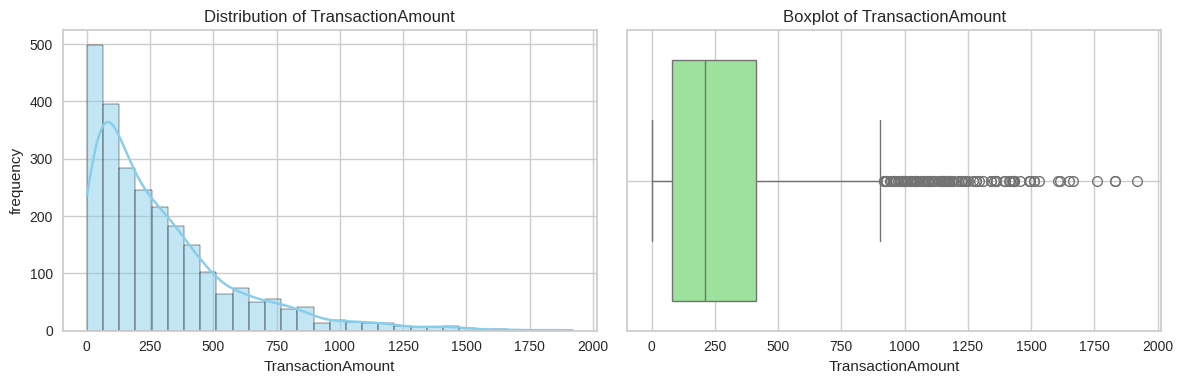

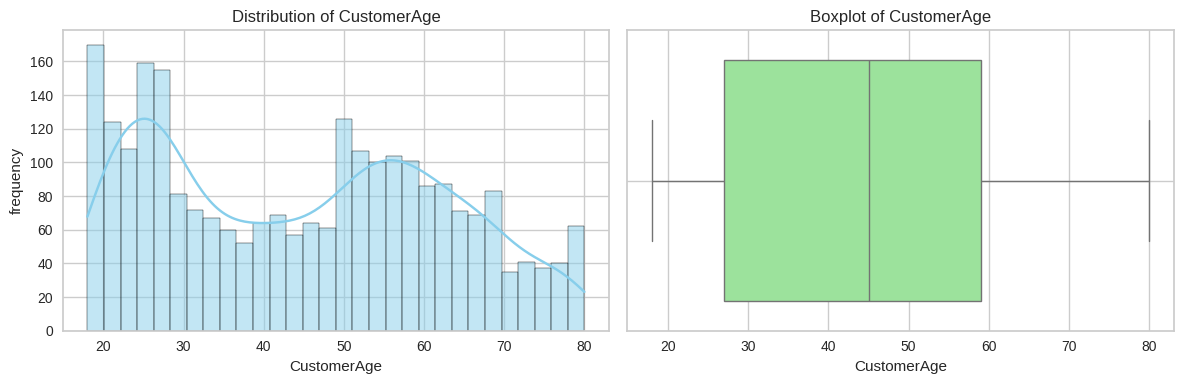

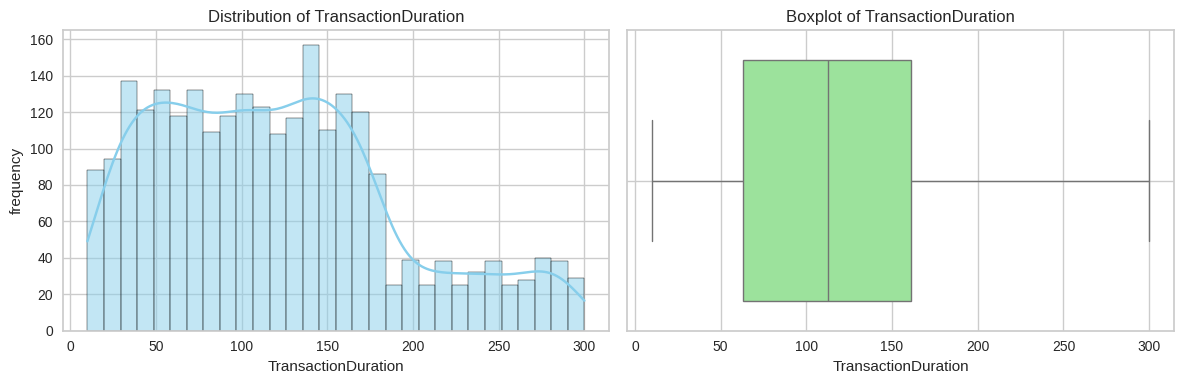

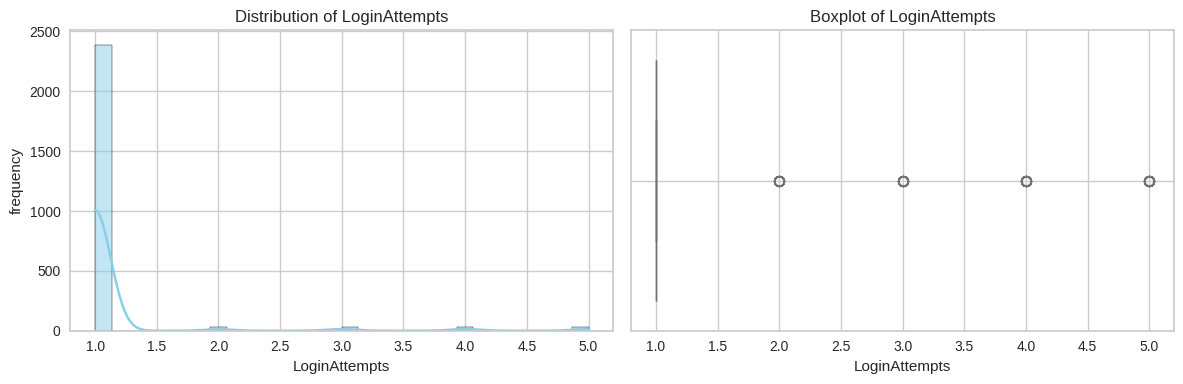

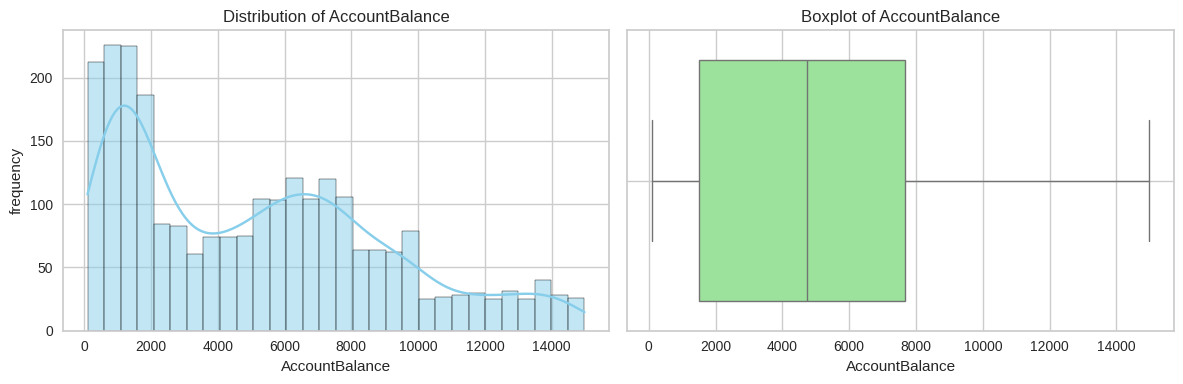

In [90]:
features = ['TransactionAmount', 'CustomerAge', 'TransactionDuration', 'LoginAttempts', 'AccountBalance']
for feature in features:
  plt.figure(figsize=(12,4))

  #Histogram
  plt.subplot(1,2,1)
  sns.histplot(x = df[feature], kde=True, bins=30, color='skyblue')
  plt.title(f'Distribution of {feature}')
  plt.xlabel(feature)
  plt.ylabel('frequency')
  plt.grid(True)

  #Boxplot
  plt.subplot(1,2,2)
  sns.boxplot(x = df[feature], color='lightgreen')
  plt.title(f'Boxplot of {feature}')
  plt.xlabel(feature)
  plt.grid(True)

  plt.tight_layout()
  plt.show()

 ### **Insight:**


**1.   Transaction Amount:**
*   Distribusi data sangat jelas terlihat skewed ke kanan (possitively skewed) yang dimana mayoritas transaksi berada dibawah 500, tetapi beberapa lainnya terdapat hingga 1900.
*   Pada boxplot juga dapat terlihat ekor kanan yang panjang yang menandakan banyak outlier pada data tersebut.


**2.   Customer Age:**
*   Usia pelanggan terdistribusi secara bimodal, yaitu terdapat 2 puncak yang cukup simetri di sekitar usia 22 dan 55 tahun. Ini bisa menandakan dua segmen pelanggan dominan (muda dan dewasa).
*   Sebaran usia cukup lebar, dari 18 sampai 80 tahun, tanpa outlier ekstrem.

**3.   Transaction Duration:**
*   Distribusi durasi transaksi pelanggan cukup simetris meski sedikit miring ke kanan (possitively skewed). Puncak frekuensi berada di rentang 50 sampai 150 detik.
*   Pada boxplot tidak terdapat outlier signifikan, sebagian besar transaksi berlangsung antara 60-170 detik, menunjukkan proses transaksi yang efisien dan stabil.

**4.   Login Attempt:**
*   Plot histogram dan boxplot sangat jelas menunjukkan percobaan login sangat miring ke kanan (positively skewed) bahwa hampir semua percobaan login hanya 1 kali dan sangat sedikit user yang melakukan percobaan login lebih dari 1 kali.
*   Sebagian besar pengguna dapat login tanpa hambatan, namun sejumlah kecil pengguna mungkin mengalami masalah autentikasi (perlu investigasi: lupa password, fraud detection, dsb).

**5.   Account Balance:**
*   Plot histogram dan boxplot terdistribusi miring ke kanan (possitively skewed) dan ekor/tail yang agak panjang di kanan (outlier) yang menunjukkan mayoritas user memiliki saldo relatif rendah dan beberapa memiliki saldo yang cukup sampai sangat besar
*   Terdapat ketimpangan saldo di antara pengguna. Sebagian besar memiliki saldo rendah, namun ada juga klien dengan saldo besar. Mungkin ini menunjukkan diferensiasi segmen: pengguna reguler vs premium.

##Bagaimana distribusi untuk data kategorial?









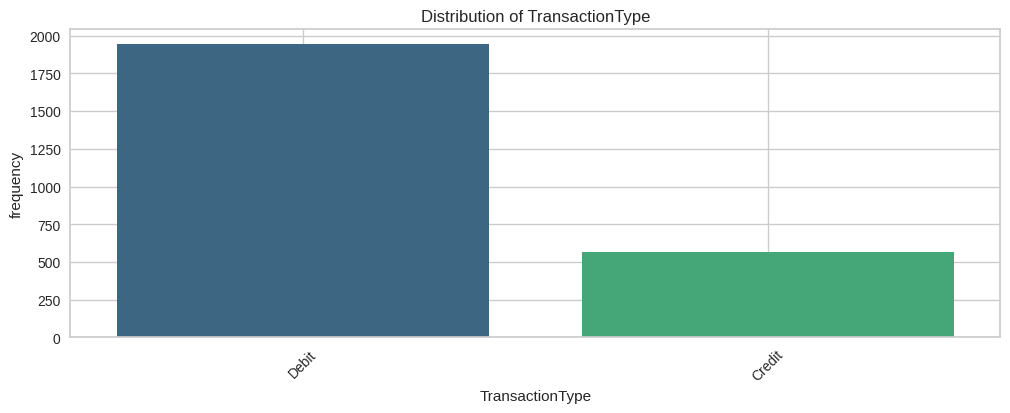

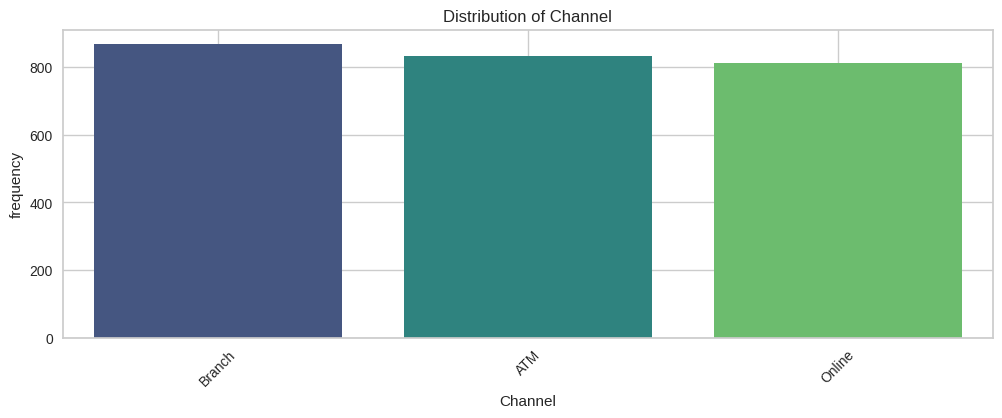

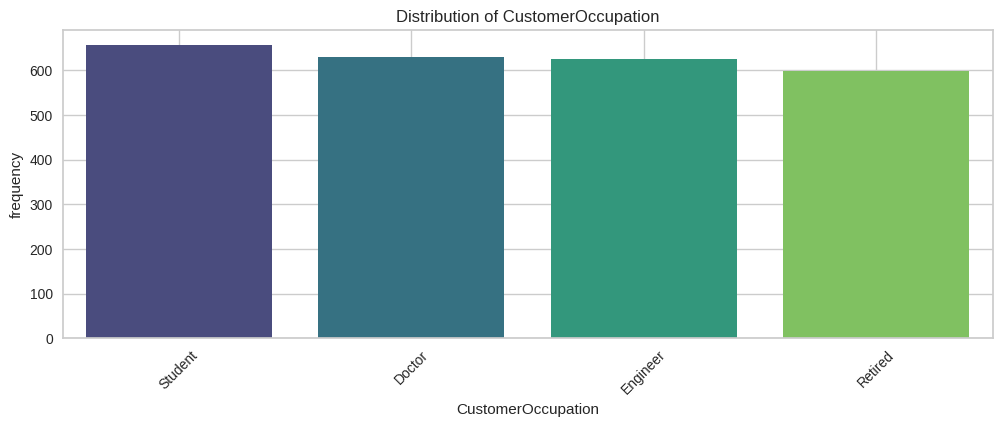

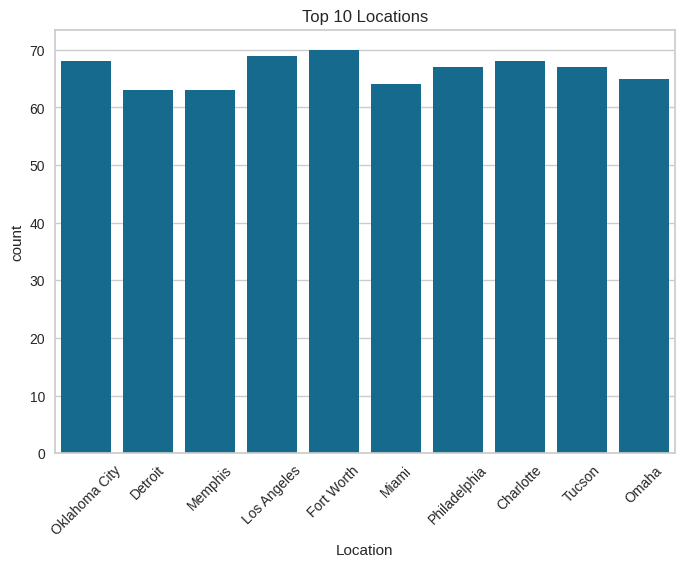

In [91]:
import warnings
warnings.filterwarnings("ignore")

# Mengambil fitur kategorikal 'penting' untuk dianalisis distribusinya
categorical_features = ['TransactionType', 'Channel', 'CustomerOccupation']
for feature in categorical_features:
  plt.figure(figsize=(12,4))
  sns.countplot(x = df[feature], palette = 'viridis', order = df[feature].value_counts().index)
  plt.title(f'Distribution of {feature}')
  plt.xlabel(feature)
  plt.ylabel('frequency')
  plt.xticks(rotation=45)
  plt.grid(True)
  plt.show()

# Mengambil 10 teratas nilai dari locations
top_locations = df['Location'].value_counts().nlargest(10).index
sns.countplot(data=df[df['Location'].isin(top_locations)], x='Location')
plt.xticks(rotation=45)
plt.title('Top 10 Locations')
plt.show()

# **5. Data Preprocessing**

Pada tahap ini, data preprocessing adalah langkah penting untuk memastikan kualitas data sebelum digunakan dalam model machine learning. Data mentah sering kali mengandung nilai kosong, duplikasi, atau rentang nilai yang tidak konsisten, yang dapat memengaruhi kinerja model. Oleh karena itu, proses ini bertujuan untuk membersihkan dan mempersiapkan data agar analisis berjalan optimal.

Berikut adalah tahapan-tahapan yang bisa dilakukan, tetapi **tidak terbatas** pada:
1. Menghapus atau Menangani Data Kosong (Missing Values)
2. Menghapus Data Duplikat
3. Normalisasi atau Standarisasi Fitur
4. Deteksi dan Penanganan Outlier
5. Encoding Data Kategorikal
6. Binning (Pengelompokan Data)

Cukup sesuaikan dengan karakteristik data yang kamu gunakan yah.

In [92]:
df['TransactionDate'] = pd.to_datetime(df['TransactionDate'])
df['PreviousTransactionDate'] = pd.to_datetime(df['PreviousTransactionDate'])
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2512 entries, 0 to 2511
Data columns (total 16 columns):
 #   Column                   Non-Null Count  Dtype         
---  ------                   --------------  -----         
 0   TransactionID            2512 non-null   object        
 1   AccountID                2512 non-null   object        
 2   TransactionAmount        2512 non-null   float64       
 3   TransactionDate          2512 non-null   datetime64[ns]
 4   TransactionType          2512 non-null   object        
 5   Location                 2512 non-null   object        
 6   DeviceID                 2512 non-null   object        
 7   IP Address               2512 non-null   object        
 8   MerchantID               2512 non-null   object        
 9   Channel                  2512 non-null   object        
 10  CustomerAge              2512 non-null   int64         
 11  CustomerOccupation       2512 non-null   object        
 12  TransactionDuration      2512 non-

Mengubah tipe data object "TransactionDate" dan "PreviousTransactionDate" menjadi tipe data datetime agar ketika proses encoding object tidak menghasilkan error/kekeliruan

In [93]:
df_cleaned = df.copy()
numeric_features = ['TransactionAmount', 'CustomerAge', 'TransactionDuration', 'AccountBalance']

for feature in numeric_features:
  Q1 = df_cleaned[feature].quantile(0.25)
  Q3 = df_cleaned[feature].quantile(0.75)
  IQR = Q3 - Q1
  Lower_bound = Q1 - 1.5 * IQR
  Upper_bound = Q3 + 1.5 * IQR

  df_cleaned = df_cleaned[(df_cleaned[feature] >= Lower_bound) & (df_cleaned[feature] <= Upper_bound)]

  print(f"Jumlah outlier pada kolom {feature}: {len(df.loc[(df[feature] < Lower_bound) | (df[feature] > Upper_bound)])}")


Jumlah outlier pada kolom TransactionAmount: 113
Jumlah outlier pada kolom CustomerAge: 0
Jumlah outlier pada kolom TransactionDuration: 0
Jumlah outlier pada kolom AccountBalance: 0


Melakukan penanganan outlier (outlier handling) dengan metode interquartil (IQR) dimana telah diidentifikasi outlier pada TransactionAmount dan LoginAttempts yang masing-masing sebanyak 113 dan 122 dan Outlier telah berhasil dihapus

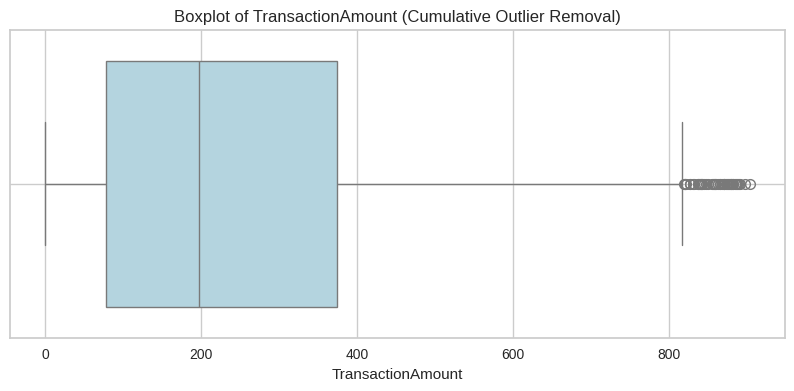

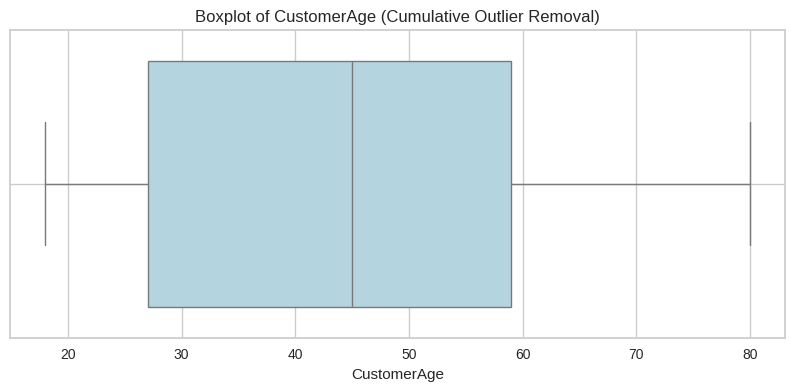

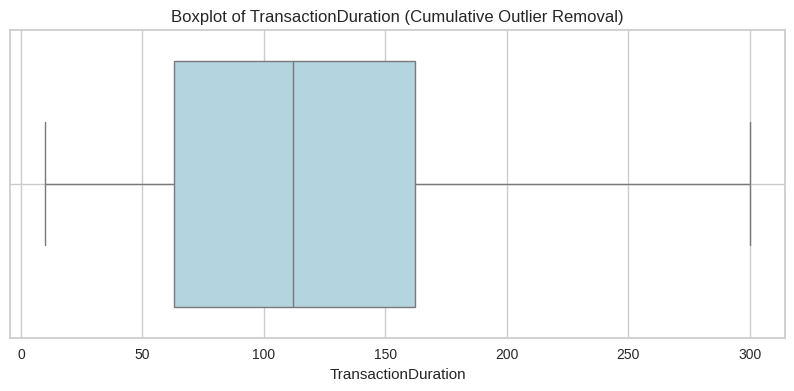

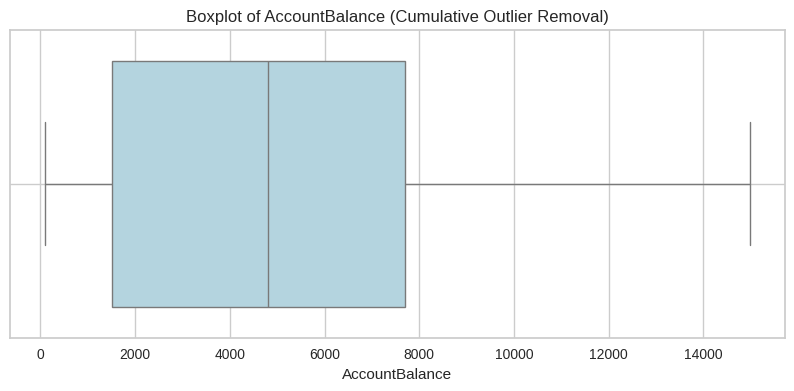

In [94]:
for feature in numeric_features:
    plt.figure(figsize=(10, 4))
    sns.boxplot(x=df_cleaned[feature], color='lightblue')
    plt.title(f'Boxplot of {feature} (Cumulative Outlier Removal)')
    plt.xlabel(feature)
    plt.grid(True)
    plt.show()

In [95]:
# Tahap Encoding
encoder = ColumnTransformer(transformers=[('cat', OneHotEncoder(drop=None), categorical_features)], remainder='passthrough')
df_encoded = pd.DataFrame(encoder.fit_transform(df_cleaned), columns = encoder.get_feature_names_out())
df_encoded.head()


,cat__TransactionType_Credit,cat__TransactionType_Debit,cat__Channel_ATM,cat__Channel_Branch,cat__Channel_Online,cat__CustomerOccupation_Doctor,cat__CustomerOccupation_Engineer,cat__CustomerOccupation_Retired,cat__CustomerOccupation_Student,remainder__TransactionID,...,remainder__TransactionDate,remainder__Location,remainder__DeviceID,remainder__IP Address,remainder__MerchantID,remainder__CustomerAge,remainder__TransactionDuration,remainder__LoginAttempts,remainder__AccountBalance,remainder__PreviousTransactionDate
0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,TX000001,...,2023-04-11 16:29:14,San Diego,D000380,162.198.218.92,M015,70,81,1,5112.21,2024-11-04 08:08:08
1,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,TX000002,...,2023-06-27 16:44:19,Houston,D000051,13.149.61.4,M052,68,141,1,13758.91,2024-11-04 08:09:35
2,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,TX000003,...,2023-07-10 18:16:08,Mesa,D000235,215.97.143.157,M009,19,56,1,1122.35,2024-11-04 08:07:04
3,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,TX000004,...,2023-05-05 16:32:11,Raleigh,D000187,200.13.225.150,M002,26,25,1,8569.06,2024-11-04 08:09:06
4,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,TX000005,...,2023-10-16 17:51:24,Atlanta,D000308,65.164.3.100,M091,26,198,1,7429.4,2024-11-04 08:06:39


Mentransformasikan fitur kategorikal (TransactionType, Channel, dan CustomerOccupation) yang berkontribusi terhadap modeling. Dengan menggunakan metode OneHotEncoder karena data tersebut bersifat nominal.

In [96]:

# Kolom numerik yang semestinya
numeric_cols = ['remainder__TransactionAmount', 'remainder__CustomerAge',
                'remainder__TransactionDuration', 'remainder__LoginAttempts',
                'remainder__AccountBalance', 'cat__TransactionType_Debit','cat__TransactionType_Credit','cat__Channel_Branch','cat__Channel_Online','cat__Channel_ATM',
                'cat__CustomerOccupation_Engineer','cat__CustomerOccupation_Retired','cat__CustomerOccupation_Student']

# Ubah semua ke float (atau int jika perlu)
for col in numeric_cols:
    df_encoded[col] = pd.to_numeric(df_encoded[col], errors='coerce')  # errors='coerce' akan ubah yang aneh jadi NaN

df_encoded.info()



<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2399 entries, 0 to 2398
Data columns (total 22 columns):
 #   Column                              Non-Null Count  Dtype         
---  ------                              --------------  -----         
 0   cat__TransactionType_Credit         2399 non-null   float64       
 1   cat__TransactionType_Debit          2399 non-null   float64       
 2   cat__Channel_ATM                    2399 non-null   float64       
 3   cat__Channel_Branch                 2399 non-null   float64       
 4   cat__Channel_Online                 2399 non-null   float64       
 5   cat__CustomerOccupation_Doctor      2399 non-null   object        
 6   cat__CustomerOccupation_Engineer    2399 non-null   float64       
 7   cat__CustomerOccupation_Retired     2399 non-null   float64       
 8   cat__CustomerOccupation_Student     2399 non-null   float64       
 9   remainder__TransactionID            2399 non-null   object        
 10  remainder__AccountID    

Setelah proses encoding ternyata ketika ditinjau fitur-fitur numeric berubah menjadi object(string). Kemudian ditangani secara manual dengan merubah fitur-fitur yang seharusnya numerik namun berubah object menjadi numerik kembali agar bisa di standarisasi pada tahap selanjutnya.

In [97]:
# Standarisasi data
numeric_encoded_features = df_encoded.select_dtypes(include=['float64', 'int64'])

scaler = StandardScaler()
scaled_array = scaler.fit_transform(numeric_encoded_features)
df_encoded_scaled = pd.DataFrame(scaled_array, columns=numeric_encoded_features.columns)

df_encoded_scaled.head()


,cat__TransactionType_Credit,cat__TransactionType_Debit,cat__Channel_ATM,cat__Channel_Branch,cat__Channel_Online,cat__CustomerOccupation_Engineer,cat__CustomerOccupation_Retired,cat__CustomerOccupation_Student,remainder__TransactionAmount,remainder__CustomerAge,remainder__TransactionDuration,remainder__LoginAttempts,remainder__AccountBalance
0,-0.543467,0.543467,1.425787,-0.730676,-0.689492,-0.576869,-0.559537,-0.593558,-1.112175,1.424991,-0.550392,-0.207599,-0.007141
1,-0.543467,0.543467,1.425787,-0.730676,-0.689492,-0.576869,-0.559537,-0.593558,0.558073,1.312326,0.306226,-0.207599,2.209057
2,-0.543467,0.543467,-0.701367,-0.730676,1.450342,-0.576869,-0.559537,1.684755,-0.594705,-1.447980,-0.907317,-0.207599,-1.029765
3,-0.543467,0.543467,-0.701367,-0.730676,1.450342,-0.576869,-0.559537,1.684755,-0.326238,-1.053651,-1.349903,-0.207599,0.878869
4,1.840038,-1.840038,-0.701367,-0.730676,1.450342,-0.576869,-0.559537,1.684755,-1.115127,-1.053651,1.120013,-0.207599,0.586767


Melakukan tahap standarisasi data pada kolom/fitur numerik dan juga yang telah di encoding

# **6. Pembangunan Model Clustering**

## **a. Pembangunan Model Clustering**

Pada tahap ini, Anda membangun model clustering dengan memilih algoritma yang sesuai untuk mengelompokkan data berdasarkan kesamaan. Berikut adalah **rekomendasi** tahapannya.
1. Pilih algoritma clustering yang sesuai.
2. Latih model dengan data menggunakan algoritma tersebut.

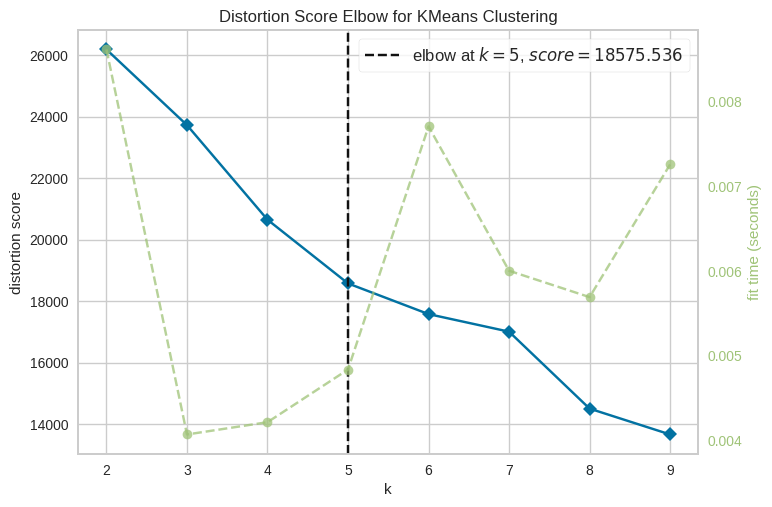

<Axes: title={'center': 'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [98]:
model = KMeans(random_state=42)
visualizer = KElbowVisualizer(model, k=(2,10))
visualizer.fit(df_encoded_scaled)
visualizer.show()

In [99]:
kmeans = KMeans(n_clusters=5, random_state=42)
kmeans.fit(df_encoded_scaled)
df_encoded_scaled['Cluster'] = kmeans.labels_
df_encoded_scaled.head()

,cat__TransactionType_Credit,cat__TransactionType_Debit,cat__Channel_ATM,cat__Channel_Branch,cat__Channel_Online,cat__CustomerOccupation_Engineer,cat__CustomerOccupation_Retired,cat__CustomerOccupation_Student,remainder__TransactionAmount,remainder__CustomerAge,remainder__TransactionDuration,remainder__LoginAttempts,remainder__AccountBalance,Cluster
0,-0.543467,0.543467,1.425787,-0.730676,-0.689492,-0.576869,-0.559537,-0.593558,-1.112175,1.424991,-0.550392,-0.207599,-0.007141,0
1,-0.543467,0.543467,1.425787,-0.730676,-0.689492,-0.576869,-0.559537,-0.593558,0.558073,1.312326,0.306226,-0.207599,2.209057,0
2,-0.543467,0.543467,-0.701367,-0.730676,1.450342,-0.576869,-0.559537,1.684755,-0.594705,-1.447980,-0.907317,-0.207599,-1.029765,4
3,-0.543467,0.543467,-0.701367,-0.730676,1.450342,-0.576869,-0.559537,1.684755,-0.326238,-1.053651,-1.349903,-0.207599,0.878869,4
4,1.840038,-1.840038,-0.701367,-0.730676,1.450342,-0.576869,-0.559537,1.684755,-1.115127,-1.053651,1.120013,-0.207599,0.586767,3


Membangun model clustering kmeans dengan terlebih dahulu menentukan hyperparameter (jumlah kluster) dengan metode elbow, kemudian menampilkan kolom cluster yang telah dibuat model kmeans ke dataframe.

## **b. Evaluasi Model Clustering**

Untuk menentukan jumlah cluster yang optimal dalam model clustering, Anda dapat menggunakan metode Elbow atau Silhouette Score.

Metode ini membantu kita menemukan jumlah cluster yang memberikan pemisahan terbaik antar kelompok data, sehingga model yang dibangun dapat lebih efektif. Berikut adalah **rekomendasi** tahapannya.
1. Gunakan Silhouette Score dan Elbow Method untuk menentukan jumlah cluster optimal.
2. Hitung Silhouette Score sebagai ukuran kualitas cluster.

In [100]:
score = silhouette_score(df_encoded_scaled, kmeans.labels_)
print(f'Silhouette score: {score}')

Silhouette score: 0.2500159088540885


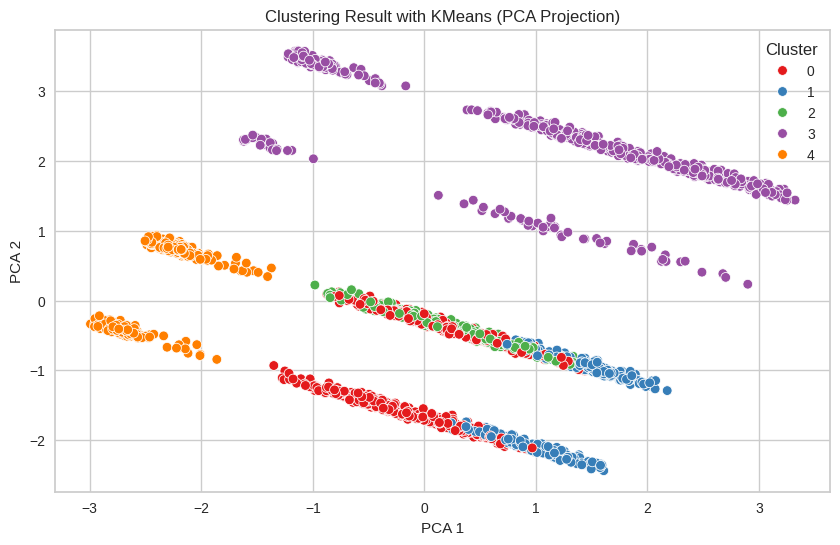

In [101]:
pca = PCA(n_components=2)
X_pca = pca.fit_transform(df_encoded_scaled.drop(columns='Cluster'))

plt.figure(figsize=(10,6))
sns.scatterplot(x=X_pca[:,0], y=X_pca[:,1], hue=df_encoded_scaled['Cluster'], palette='Set1')
plt.title('Clustering Result with KMeans (PCA Projection)')
plt.xlabel('PCA 1')
plt.ylabel('PCA 2')
plt.grid(True)
plt.show()


Pada tahap evaluasi model clustering, menggunakan metode silhoutte score dan didapat score silhoutte sekitar 0.25. Skor yang diperoleh dari evaluasi sangat kecil, meskipun data yang inputkan sudah melalui tahap pemilihan manual, encoding, dan standarisasi. Kemudian data dari hasil model divisualisasikan dengan metode PCA.


## **c. Feature Selection (Opsional)**

Silakan lakukan feature selection jika Anda membutuhkan optimasi model clustering. Jika Anda menerapkan proses ini, silakan lakukan pemodelan dan evaluasi kembali menggunakan kolom-kolom hasil feature selection. Terakhir, bandingkan hasil performa model sebelum dan sesudah menerapkan feature selection.

In [102]:
from sklearn.feature_selection import VarianceThreshold

selector = VarianceThreshold(threshold=0.01)
X_selected = selector.fit_transform(df_encoded_scaled.drop(columns='Cluster'))

In [103]:
kmeans_fs = KMeans(n_clusters=5, random_state=42)
kmeans_fs.fit(X_selected)
labels_kmeans_fs = kmeans_fs.labels_
score_kmeans_fs = silhouette_score(X_selected, labels_kmeans_fs)
print(f'Silhouette score after feature selection: {score_kmeans_fs}')

Silhouette score after feature selection: 0.19384907231011175


Karena score silhouette pada model clustering diawal sangat kecil, kami mengasumsikan bahwa fitur data harus reduksi dengan feature selection melalui metode Variance Threshold dan kembali membuat ulang model clustering serta score silhouette nya, namun score menunjukkan hasil yang lebih buruk dari score evaluasi awal yaitu menurun menjadi sekitar 0.19.


## **Create ulang model clustering dengan DBSCAN**

In [104]:
# DBSCAN model (lama)
dbscan = DBSCAN(eps=0.78, min_samples=40)
numerical_cols = df_encoded_scaled.select_dtypes(include=['float64', 'int64']).columns
labels_dbscan = dbscan.fit_predict(df_encoded_scaled[numerical_cols])

# Simpan label
df_encoded_scaled['Cluster_DBSCAN'] = labels_dbscan

# Hitung silhouette score
mask = labels_dbscan != -1
if mask.sum() > 1:
    score = silhouette_score(df_encoded_scaled.loc[mask, numerical_cols], labels_dbscan[mask])
    print(f"Silhouette Score DBSCAN (tanpa outlier): {score}")
else:
    print("Terlalu banyak outlier, silhouette score tidak bisa dihitung.")

Silhouette Score DBSCAN (tanpa outlier): 0.7340175332933766


Karena algoritma model kmeans tidak menunjukkan hasil yang baik terhadap data meskipun sudah dilakukan feature selection, kami mencoba membuat model algoritma lain yaitu DBSCAN yang "ramah terhadap outlier" pada dataset. Kemudian hasil evaluasi menunjukkan performa model yang baik yaitu sekitar 0.7.

In [105]:
# Mapping deskriptif
label_mapping = {
    -1: 'Fraud (Outliers)',
    0: 'Normal',
    1: 'Normal',
    2: 'Normal',
    3: 'Normal'
}
df_encoded_scaled['Cluster_Description'] = df_encoded_scaled['Cluster_DBSCAN'].map(label_mapping)

print(df_encoded_scaled['Cluster_Description'].value_counts())
df_encoded_scaled.drop(columns=['Cluster']).head()

Cluster_Description
Fraud (Outliers)    2220
Normal               179
Name: count, dtype: int64


,cat__TransactionType_Credit,cat__TransactionType_Debit,cat__Channel_ATM,cat__Channel_Branch,cat__Channel_Online,cat__CustomerOccupation_Engineer,cat__CustomerOccupation_Retired,cat__CustomerOccupation_Student,remainder__TransactionAmount,remainder__CustomerAge,remainder__TransactionDuration,remainder__LoginAttempts,remainder__AccountBalance,Cluster_DBSCAN,Cluster_Description
0,-0.543467,0.543467,1.425787,-0.730676,-0.689492,-0.576869,-0.559537,-0.593558,-1.112175,1.424991,-0.550392,-0.207599,-0.007141,-1,Fraud (Outliers)
1,-0.543467,0.543467,1.425787,-0.730676,-0.689492,-0.576869,-0.559537,-0.593558,0.558073,1.312326,0.306226,-0.207599,2.209057,-1,Fraud (Outliers)
2,-0.543467,0.543467,-0.701367,-0.730676,1.450342,-0.576869,-0.559537,1.684755,-0.594705,-1.447980,-0.907317,-0.207599,-1.029765,-1,Fraud (Outliers)
3,-0.543467,0.543467,-0.701367,-0.730676,1.450342,-0.576869,-0.559537,1.684755,-0.326238,-1.053651,-1.349903,-0.207599,0.878869,-1,Fraud (Outliers)
4,1.840038,-1.840038,-0.701367,-0.730676,1.450342,-0.576869,-0.559537,1.684755,-1.115127,-1.053651,1.120013,-0.207599,0.586767,-1,Fraud (Outliers)


## **d. Visualisasi Hasil Clustering**

Setelah model clustering dilatih dan jumlah cluster optimal ditentukan, langkah selanjutnya adalah menampilkan hasil clustering melalui visualisasi.

Berikut adalah **rekomendasi** tahapannya.
1. Tampilkan hasil clustering dalam bentuk visualisasi, seperti grafik scatter plot atau 2D PCA projection.

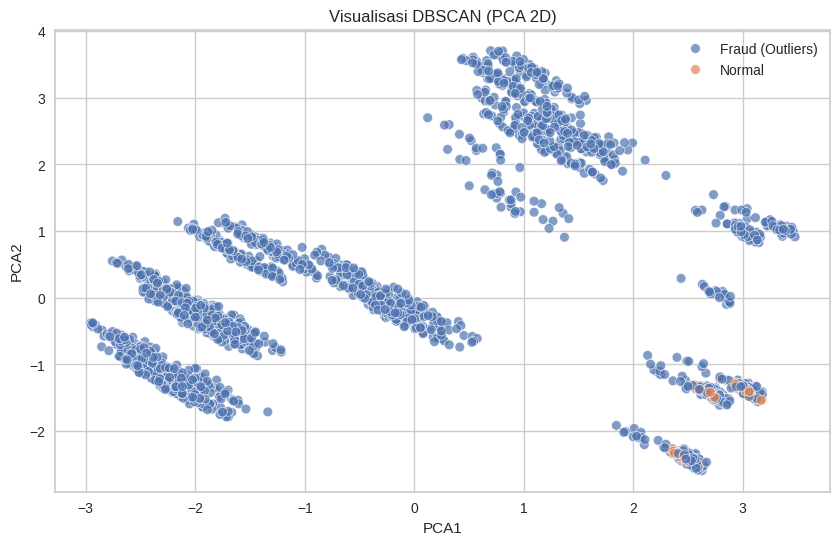

In [106]:
# PCA untuk visualisasi
pca = PCA(n_components=2)
pca_result = pca.fit_transform(df_encoded_scaled.drop(columns=['Cluster_DBSCAN', 'Cluster_Description']))
df_encoded_scaled['PCA1'] = pca_result[:, 0]
df_encoded_scaled['PCA2'] = pca_result[:, 1]

# Plot visualisasi
plt.figure(figsize=(10, 6))
sns.scatterplot(
    data=df_encoded_scaled,
    x='PCA1', y='PCA2',
    hue='Cluster_Description',
    palette='deep',
    alpha=0.7
)
plt.title('Visualisasi DBSCAN (PCA 2D)')
plt.legend(loc='best')
plt.show()


## **e. Analisis dan Interpretasi Hasil Cluster**

In [107]:
def analyze_clusters_dbscan(df, cluster_column):
    print("=== Analisis Karakteristik Tiap Cluster Berdasarkan Mean ===")
    clusters = sorted(df[cluster_column].unique())

    # Pisahkan fitur numerik dan kategorikal
    numerical_cols = [col for col in df.columns if col.startswith('remainder__')]
    categorical_cols = [col for col in df.columns if col.startswith('cat__')]

    for cluster_id in clusters:
        cluster_data = df[df[cluster_column] == cluster_id]
        print(f"\nCluster {cluster_id} ({'Fraud (Outliers)' if cluster_id == -1 else 'Normal'}):")
        print(f"Jumlah data: {len(cluster_data)}")

        print("\n  >> Rata-rata Fitur Numerik:")
        for col in numerical_cols:
            mean_val = cluster_data[col].mean()
            print(f"    - {col}: {mean_val:.2f}")

        print("\n  >> Proporsi Fitur Kategorikal:")
        for col in categorical_cols:
            prop = cluster_data[col].mean()
            print(f"    - {col}: {prop:.2f}")


analyze_clusters_dbscan(df_encoded_scaled, 'Cluster_DBSCAN')




=== Analisis Karakteristik Tiap Cluster Berdasarkan Mean ===

Cluster -1 (Fraud (Outliers)):
Jumlah data: 2220

  >> Rata-rata Fitur Numerik:
    - remainder__TransactionAmount: 0.05
    - remainder__CustomerAge: 0.10
    - remainder__TransactionDuration: 0.04
    - remainder__LoginAttempts: 0.02
    - remainder__AccountBalance: 0.08

  >> Proporsi Fitur Kategorikal:
    - cat__TransactionType_Credit: 0.04
    - cat__TransactionType_Debit: -0.04
    - cat__Channel_ATM: 0.00
    - cat__Channel_Branch: 0.00
    - cat__Channel_Online: -0.01
    - cat__CustomerOccupation_Engineer: 0.05
    - cat__CustomerOccupation_Retired: 0.05
    - cat__CustomerOccupation_Student: -0.14

Cluster 0 (Normal):
Jumlah data: 59

  >> Rata-rata Fitur Numerik:
    - remainder__TransactionAmount: -0.61
    - remainder__CustomerAge: -1.19
    - remainder__TransactionDuration: -0.96
    - remainder__LoginAttempts: -0.21
    - remainder__AccountBalance: -1.02

  >> Proporsi Fitur Kategorikal:
    - cat__Transactio


##Cluster Fraud
####**1.  Cluster -1**
*   Jumlah/nominal transaksi sedikit diatas rata-rata atau sedikit tinggi
*   Usia pelanggan cenderung sedikit lebih tua
*   Durasi transaksi sedikit diatas rata-rata namun cenderung normal
*   Percobaan login sedikit diatas rata-rata
*   Saldo akun user sedikit lebih tinggi
*   Tipe transaksi cenderung sedikit lebih banyak kredit dibanding debit
*   Channel transaksi user cenderung hampir mendekati rata-rata yang berarti normal
*   Okupasi Pelanggan cenderung lebih banyak ke engineer dan retired, sedangkan mahasiswa sedikit

**Interpretasi:** Dugaan Transaksi Fraud cenderung mememiliki karakteristik: Nominal transaksi dan saldo yang tinggi, Usia user lebih tua, Percobaan login yang lebih tinggi (lebih dari 1 kali) yang memungkinkan brute force, dan okupasi user ialah engineer dan retired, sedangkan mahasiswa sedikit (sejalan dengan usia user)

##Cluster Normal
####**2.  Cluster 0**
*   Jumlah/nominal transaksi user lebih kecil pada cluster ini
*   Usia pelanggan pada cluster ini jauh lebih muda
*   Durasi transaksi sedikit diatas rata-rata namun cenderung normal
*   Percobaan login dibawah rata rata (1 kali attempt)
*   Saldo akun user jauh lebih sedikit
*   Tipe transaksi cenderung sedikit lebih banyak debit dibanding kredit
*   Channel transaksi user lebih signifikan pada online daripada branch dan ATM
*   Okupasi Pelanggan lebih banyak mahasiswa dibanding engineer dan retired

####**3.  Cluster 1**
*   Jumlah/nominal transaksi user lebih kecil pada cluster ini
*   Usia pelanggan pada cluster ini jauh lebih muda
*   Durasi transaksi dibawah rata-rata atau durasi transaksi lebih cepat
*   Percobaan login dibawah rata rata (1 kali attempt)
*   Saldo akun user jauh lebih sedikit
*   Tipe transaksi cenderung sedikit lebih banyak debit dibanding kredit
*   Channel transaksi user lebih signifikan pada branch daripada online dan ATM
*   Okupasi Pelanggan lebih banyak mahasiswa dibanding engineer dan retired

####**4.  Cluster 2**
*   Jumlah/nominal transaksi user lebih kecil pada cluster ini
*   Usia pelanggan pada cluster ini jauh lebih muda
*   Durasi transaksi dibawah rata-rata atau durasi transaksi lebih cepat
*   Percobaan login dibawah rata rata (1 kali attempt)
*   Saldo akun user jauh lebih sedikit
*   Tipe transaksi cenderung sedikit lebih banyak debit dibanding kredit
*   Channel transaksi user lebih signifikan pada ATM daripada online dan branch
*   Okupasi Pelanggan lebih banyak mahasiswa dibanding engineer dan retired

**Interpretasi:** Pengguna di cluster normal ini lebih muda dan mayoritas adalah mahasiwa, percobaan login relatif sangat normal (tidak ada rata-rata diatas 1 kali), transaksinya lebih kecil, dan saldonya lebih sedikit. Serta pada channel transaksi tersegmentasi masing-masing pada tiap cluster yang berarti normal.

## Konklusi: Fraud vs Normal

*   Jumlah/nominal transaksi pada fraud 0.06 dan pada normal sekitar -0.6 --> Sedikit lebih tinggi dari normal, mengindikasikan potensi transaksi dengan jumlah abnormal (bisa skimming, overcharging, dll).
*   Usia customer/user pada fraud 0.12 dan normal sekitar -1.2 --> indikasi pengguna fraud berusia lebih tua atau lebih berpengalaman

*   Durasi transaksi pada fraud 0.04 dan normal -0.4 ~ -0.7 --> indikasi pengguna fraud menggunakan waktu lebih banyak dalam upaya memanipulasi transaksi, multiple step, dan lain sebagainya.
*   Percobaan Login pada fraud 0.02 dan normal -0.21 --> indikasi pengguna fraud melakukan upaya login cenderung diatas satu kali, memungkinkan upaya brute force, dll

*   Saldo akun pada Fraud 0.10 dan normal -1.04 --> indikasi pengguna fraud seringkali membidik akun-akun customer yang memiliki saldo besar, agar nilai keuntungan yang diperoleh tinggi.

*   Tipe transaksi kredit pada Fraud 0.05 dan Normal -0.54 --> Kredit sedikit lebih banyak karena fraud kadang melibatkan dana masuk (misalnya pengembalian palsu, chargeback, refund abuse). Tipe transaksi debit Fraud -0.05 dan normal 0.54 --> Debit lebih jarang karena fraud tidak langsung menarik dana, bisa delay time atau skenario penipuan ganda (masuk dulu, keluar nanti).

*   Channel transaksi fraud dan normal masing-masing variasinya tidak signifikan cenderung mendekati 0 yang berarti normal dan tidak menjadi indikator.

*   Okupasi engineer customer pada fraud 0.06 dan normal -0.58 --> Fraud bisa melibatkan user berpengetahuan teknis → engineer berpotensi mampu eksploitasi sistem (bot, script, manipulasi API). Okupasi retired customer pada fraud 0.05 dan normal -0.56 --> Fraud dapat dapat melibatkan user yang sudah tidak bekerja atau pensiun dengan alibi membutuhkan biaya. Okupasi customer mahasiswa fraud -0.16 dan normal 1.68 --> mahasiswa mendominasi transaksi dalam cluster normal yang kecil diindikasikan pelaku fraud.








# **7. Mengeksport Data**

Simpan hasilnya ke dalam file CSV.

In [112]:
#cek dataframe saat ini
df_export = df_encoded_scaled.copy()
print(df_export.columns)

#membuang kolom pca dan cluster karena tidak sesuai
df_export.drop(columns=['Cluster', 'PCA1','PCA2'], inplace = True)
df_export.head()

Index(['cat__TransactionType_Credit', 'cat__TransactionType_Debit',
       'cat__Channel_ATM', 'cat__Channel_Branch', 'cat__Channel_Online',
       'cat__CustomerOccupation_Engineer', 'cat__CustomerOccupation_Retired',
       'cat__CustomerOccupation_Student', 'remainder__TransactionAmount',
       'remainder__CustomerAge', 'remainder__TransactionDuration',
       'remainder__LoginAttempts', 'remainder__AccountBalance', 'Cluster',
       'Cluster_DBSCAN', 'Cluster_Description', 'PCA1', 'PCA2'],
      dtype='object')


,cat__TransactionType_Credit,cat__TransactionType_Debit,cat__Channel_ATM,cat__Channel_Branch,cat__Channel_Online,cat__CustomerOccupation_Engineer,cat__CustomerOccupation_Retired,cat__CustomerOccupation_Student,remainder__TransactionAmount,remainder__CustomerAge,remainder__TransactionDuration,remainder__LoginAttempts,remainder__AccountBalance,Cluster_DBSCAN,Cluster_Description
0,-0.543467,0.543467,1.425787,-0.730676,-0.689492,-0.576869,-0.559537,-0.593558,-1.112175,1.424991,-0.550392,-0.207599,-0.007141,-1,Fraud (Outliers)
1,-0.543467,0.543467,1.425787,-0.730676,-0.689492,-0.576869,-0.559537,-0.593558,0.558073,1.312326,0.306226,-0.207599,2.209057,-1,Fraud (Outliers)
2,-0.543467,0.543467,-0.701367,-0.730676,1.450342,-0.576869,-0.559537,1.684755,-0.594705,-1.447980,-0.907317,-0.207599,-1.029765,-1,Fraud (Outliers)
3,-0.543467,0.543467,-0.701367,-0.730676,1.450342,-0.576869,-0.559537,1.684755,-0.326238,-1.053651,-1.349903,-0.207599,0.878869,-1,Fraud (Outliers)
4,1.840038,-1.840038,-0.701367,-0.730676,1.450342,-0.576869,-0.559537,1.684755,-1.115127,-1.053651,1.120013,-0.207599,0.586767,-1,Fraud (Outliers)


In [113]:
#Simpan ke CSV dan ke Drive

df_export.to_csv('/content/drive/MyDrive/Submission Dicoding/hasil_clustering_frauds_detection.csv', index = False)